In [119]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
#uncomment for remote
pgport=3333
#pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [120]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


In [121]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%';

1 rows affected.


count
2


In [274]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%Failed t
     o parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred lZocation%') as possible_cg_unsound,
    (select count(*) from jobs) as Total_Jobs

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


completed_jobs,paused_jobs,acquired_jobs,body_exception,exception,refl_exception,worker_failure,possible_cg_unsound,total_jobs
196,0,0,12,12,0,0,0,196


71 2:29 am
117 850 am
127 11:00 am 

Failing apks

In [222]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception' group by cast(config::json->'apkPath' as text) ;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


text


In [112]:
# err = %sql select stderr from jobs where stderr like '%Exception%' order by random() limit 1;
# print(err.DataFrame()['stderr'][0])
%sql select count(id) from jobs where stderr like '%The database file is locked%';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
22


In [260]:
err = %sql select (config::json->'initialQuery'->>0) as classname,stderr from jobs \
    where stderr like '%Exception%' and stderr not like '%no active body%' order by random() limit 1;
df = err.DataFrame()
print(df['classname'][0])
print(df['stderr'][0][:400])

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.
{"t":"AllReceiversNonNull","className":"com.serwylo.lexica.PlayLexica$1"}
java.util.concurrent.TimeoutException: Future timed out after [600 seconds]
	at scala.concurrent.impl.Promise$DefaultPromise.tryAwait0(Promise.scala:212)
	at scala.concurrent.impl.Promise$DefaultPromise.result(Promise.scala:225)
	at scala.concurrent.Await$.$anonfun$result$1(package.scala:201)
	at scala.concurrent.BlockContext$DefaultBlockContext$.blockOn(BlockContext.scala:62)
	at scala.concurrent


In [49]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

 * postgresql://postgres@localhost:3333/postgres
2 rows affected.


app,count
"""${baseDir}/itkach.aard2/0.43/apk/itkach.aard2_43.apk""",119
"""${baseDir}/com.serwylo.lexica/0.12.0/apk/com.serwylo.lexica_1200.apk""",77


In [142]:
%%sql
select count(*),status from jobs group by status;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count,status
196,new


In [8]:
%%sql
select count(*) from jobs where status like '%Exception%';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
0


In [6]:
%%sql
select count(*) from jobs where status = 'acquired';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
1


In [275]:
%%sql 
select cast(result::json->'summary' as varchar) as summary, cast(result::json->'maxPathCh' as varchar) as ch,count(*) from results group by summary,ch;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


summary,ch,count
"""\""Witnessed\""""","""\""MultiCallback\""""",72
"""\""Proven\""""","""\""SingleCallbackMultiMethod\""""",40
"""\""Unreachable\""""","""\""SingleMethod\""""",365
"""\""Proven\""""","""\""MultiCallback\""""",31
"""\""Proven\""""","""\""SingleMethod\""""",715


In [ ]:
%%sql


TODO:
- use some other tool to get rid of simple deref like hopper

- [ ] break down proven number more and remove trivial things e.g.
void myMethod(v){
   v.foo(); // alarm
   v.bar(); // no alarm
 
- [ ] motivate why type based techniques aren't enough

Triage witness results
----------------------

In [206]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where cast(result::json->'summary' as varchar) like '%Witnessed%' order by random() limit 10;

 * postgresql://postgres@localhost:3333/postgres
10 rows affected.


id,jobid,resultdata,clazz,?column?
40,73,228,itkach.aard2.FileSelectListAdapter$1,"[""itkach.aard2.FileSelectListAdapter$1"",""java.io.File""]"
133,53,244,itkach.aard2.FileSelectListAdapter$2,"[""itkach.aard2.FileSelectListAdapter$2"",""java.io.File"",""java.io.File""]"
163,177,248,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica""]"
78,83,232,itkach.aard2.DictionaryListAdapter$3,"[""itkach.aard2.DictionaryListAdapter$3"",""android.view.View""]"
168,177,248,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica"",""int""]"
174,177,248,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica""]"
139,53,244,itkach.aard2.FileSelectListAdapter$2,"[""itkach.aard2.FileSelectListAdapter$2"",""java.io.File"",""java.io.File""]"
155,177,248,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica""]"
149,177,248,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica""]"
91,83,232,itkach.aard2.DictionaryListAdapter$3,"[""itkach.aard2.DictionaryListAdapter$3"",""android.view.View""]"


In [215]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'line'->'str' as varchar),'$','\$') from results where id = 40;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


id,jobid,resultdata,clazz,replace
40,73,228,itkach.aard2.FileSelectListAdapter$1,"""line: 34 \$z0 = virtualinvoke \$r1.<java.io.File: boolean isDirectory()>()"""


Triage unreachable results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
            from results where cast(result::json->'summary' as varchar) like '%Unreachable%' 
            order by random() limit 5;

TODO


In [ ]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 15037;

In [ ]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

In [ ]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

Runtime Stats
=============

 * postgresql://postgres@localhost:3333/postgres
3026 rows affected.


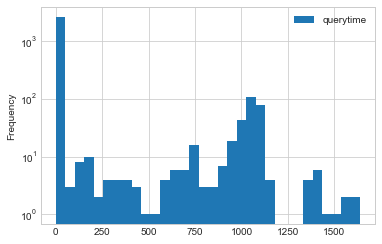

In [247]:
queryTime = %sql select querytime from results;
tplt = queryTime.DataFrame().plot.hist(bins=32)
tplt.set_yscale('log')

 * postgresql://postgres@localhost:3333/postgres
195 rows affected.


Text(0.5, 0, 'time (min)')

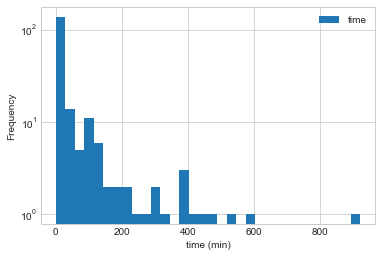

In [248]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:3333/postgres
195 rows affected.


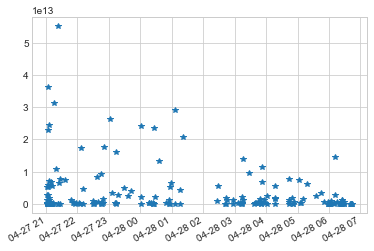

In [246]:
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [16]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


sum
0:01:13.608000


In [17]:
%%sql
select sum(querytime) from results;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


sum
13


In [233]:
%%sql
select now() - min(started) from jobs;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


?column?
6:33:26.412899


Size of postgres data
=====================

In [193]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,apks,0.0,64 MB,0 bytes,64 MB,8192 bytes
public,resultdata,4.0,1128 kB,16 kB,1056 kB,56 kB
pg_catalog,pg_depend,7725.0,1120 kB,624 kB,None,496 kB
pg_catalog,pg_proc,3034.0,1024 kB,336 kB,8192 bytes,680 kB
pg_catalog,pg_attribute,2861.0,688 kB,216 kB,None,472 kB


Inspection of exceptions
========================

In [ ]:
%%sql
select id,replace(stderr,'$','\$') from jobs where stderr like '%Exception%' and stderr 
    not like '%no active body%' order by random() limit 3;

In [ ]:
#count of total results
%sql select count(*) as Total_locations_computed from results

- focus on writing specification for existing witnesses 

z3 encoding notes

- indexes as integers may be slowing things down
   - paper 2016 padon - paxos made epr
   - exists relation < transitive 
   - forall i,j,k . j<k & ...
   - uninterpreted sort t0 forall i,j . j<i \/ i<j
- write down sat/unsat properly  section 4
   - use algebraic reasoning to say when we dont need to call z3
                                                   

SAT(O,S,\rho,P) 
                                                   
 - O - trace suffix with symbolic variables
 - S - set of specifications, framework model

- [ ] can we partition locations into places that are "reasonably sound"
- [ ] easier story to say "we did every dereference site" for 6 apps
- [ ] witnessed is a terrible name, should be "alarm"